# Food Price Prediction Model using LightGBM

In [1]:
#importing necessary libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn import utils
import category_encoders as ce
gc.enable()

### Importing and taking a look at the data

In [2]:
#importing and splitting the data into training and testing sets
df = pd.read_csv('https://raw.githubusercontent.com/NeeXann/Predicting-Food-Prices-in-PH-using-LightGBM/main/wfp_food_prices_phl.csv')
df.head()

C:\Users\63926\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (4,5,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#geo+lat,#geo+lon,#item+type,#item+name,#item+unit,#item+price+type,#currency,#value,#value+usd
1,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,cereals and tubers,Maize flour (yellow),KG,actual,PHP,15.0,0.3
2,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,cereals and tubers,"Rice (milled, superior)",KG,actual,PHP,18.35,0.36
3,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,cereals and tubers,"Rice (regular, milled)",KG,actual,PHP,16.35,0.32
4,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,"meat, fish and eggs",Meat (pork),KG,actual,PHP,105.37,2.09


In [3]:
#Removing the index rows
df = df.drop(labels=[0], axis=0)
df.head()

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,pricetype,currency,price,usdprice
1,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,cereals and tubers,Maize flour (yellow),KG,actual,PHP,15.0,0.3
2,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,cereals and tubers,"Rice (milled, superior)",KG,actual,PHP,18.35,0.36
3,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,cereals and tubers,"Rice (regular, milled)",KG,actual,PHP,16.35,0.32
4,2000-01-15,National Capital region,Metropolitan Manila,Metro Manila,14.604167,120.982222,"meat, fish and eggs",Meat (pork),KG,actual,PHP,105.37,2.09
5,2000-01-15,Region III,Nueva Ecija,Palayan,15.5415,121.0848,cereals and tubers,"Rice (milled, superior)",KG,actual,PHP,18.0,0.36


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87751 entries, 1 to 87751
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       87751 non-null  object
 1   admin1     87751 non-null  object
 2   admin2     87751 non-null  object
 3   market     87751 non-null  object
 4   latitude   87751 non-null  object
 5   longitude  87751 non-null  object
 6   category   87751 non-null  object
 7   commodity  87751 non-null  object
 8   unit       87751 non-null  object
 9   pricetype  87751 non-null  object
 10  currency   87751 non-null  object
 11  price      87751 non-null  object
 12  usdprice   87751 non-null  object
dtypes: object(13)
memory usage: 9.4+ MB


The dtypes will be changed to their corresponding types later for the machine to recognize them.

### Preperation of the Data

Now, looking at the table, the relevant factors that determine the price of the food in this table are location(market), category, and commodity (common name) so I will extract those columns from the dataset. Also, I will use the price of the foods in Philippine Peso as the dependent variable.

In [5]:
#extracting the feature variables and making their type as category
features = df[['market','category', 'commodity']]
features = features.astype('category')
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87751 entries, 1 to 87751
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   market     87751 non-null  category
 1   category   87751 non-null  category
 2   commodity  87751 non-null  category
dtypes: category(3)
memory usage: 950.4 KB


In [6]:
#extrecting the price and converting its type into float64
price = df[['price']]
price = price.astype(float)
price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87751 entries, 1 to 87751
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   87751 non-null  float64
dtypes: float64(1)
memory usage: 1.3 MB


In [7]:
#Creating the train test dataset (splitting by 50%)
data_train, data_test, price_train, price_test = train_test_split(features,price, test_size=0.5, random_state=14, stratify=features[['commodity']])

In this case, the 'data_train' and 'price train' are used to train the model and the 'data_test and 'price_test' are used to measure the overfitting of the model.

### Implementing LightGBM

In [8]:
#preparing the train data
X_train, X_test, y_train, y_test = train_test_split(data_train, price_train, test_size = 0.2, random_state = 14, stratify=data_train[['commodity']])

In [9]:
#lightgbm model
clf = lgb.LGBMRegressor(num_leaves= 14, max_depth = 17, 
                         random_state = 314, 
                         silent = True,
                         objective = 'regression',
                         categorical_feature = ['market', 'commodity'],
                         metric = 'auc', 
                         device_type = 'cpu',
                         n_estimators = 1000,
                         colsample_bytree = 0.9,
                         subsample = 0.8,
                         bagging_freq = 7,
                         learning_rate = 0.1, 
                       )

In [10]:
clf.fit(X_train, y_train, eval_set = [(X_test,y_test)],eval_metric = 'l1', early_stopping_rounds = 1000)

C:\Users\63926\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\63926\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\63926\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python3

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[1]	valid_0's l1: 64.2067	valid_0's auc: 1
[2]	valid_0's l1: 58.617	valid_0's auc: 1
[3]	valid_0's l1: 53.6365	valid_0's auc: 1
[4]	valid_0's l1: 49.1857	valid_0's auc: 1
[5]	valid_0's l1: 45.2869	valid_0's auc: 1
[6]	valid_0's l1: 41.8345	valid_0's auc: 1
[7]	valid_0's l1: 38.7839	valid_0's auc: 1
[8]	valid_0's l1: 36.1287	valid_0's auc: 1
[9]	valid_0's l1: 33.8042	valid_0's auc: 1
[10]	valid_0's l1: 31.7579	valid_0's auc: 1
[11]	valid_0's l1: 29.9691	valid_0's auc: 1
[12]	valid_0's l1: 28.4359	valid_0's auc: 1
[13]	valid_0's l1: 27.0959	valid_0's auc: 1
[14]	valid_0's l1: 25.9654	valid_0's auc: 1
[15]	valid_0's l1: 24.902	valid_0's auc: 1
[16]	valid_0's l1: 24.0456	valid_0's auc: 1
[17]	valid_0's l1: 23.2441	valid_0's auc: 1
[18]	valid_0's l1: 22.6076	valid_0's auc: 1
[19]	valid_0's l1: 22.0596	valid_0's auc: 1
[20]	valid_0's l1: 21.5825	valid_0's auc: 1
[21]	valid_0's l1: 21.1

LGBMRegressor(bagging_freq=7, categorical_feature=['market', 'commodity'],
              colsample_bytree=0.9, device_type='cpu', max_depth=17,
              metric='auc', n_estimators=1000, num_leaves=14,
              objective='regression', random_state=314, silent=True,
              subsample=0.8)

In [11]:
#Testing the accuracy of the created model
print('Training accuracy: {:.4f}'.format(clf.score(X_train,y_train)))
print('Training accuracy: {:.4f}'.format(clf.score(X_test,y_test)))

Training accuracy: 0.9577
Training accuracy: 0.9447


In [12]:
#Testing the accuracy of the model on the untouched data to measure the overfitting
print('Training accuracy: {:.4f}'.format(clf.score(data_test,price_test)))

Training accuracy: 0.9458


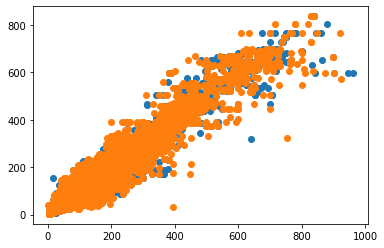

In [13]:
#Creating the predicted values of the model and generating the scatterplot between the predicted price and the actual price of the foods.
y_pred = clf.predict(X_train)
y_pred_t = clf.predict(data_test)
mat=plt.scatter(y_train, y_pred)
mat_test=plt.scatter(price_test, y_pred_t)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

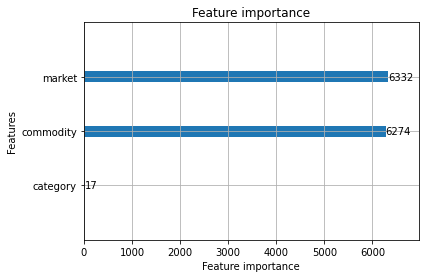

In [14]:
lgb.plot_importance(clf)